In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability.python.mcmc.transformed_kernel import make_transformed_log_prob
import arviz as az
import pymc4 as pm4
import pymc3 as pm3
import seaborn as sns

tfd = tfp.distributions
tfb = tfp.bijectors

dtype = tf.float32
plt.style.use("arviz-darkgrid")

np.random.seed(42)
pm3.set_tt_rng(42)
tf.random.set_seed(42)

## Convergence Checks

#### There is no frequency option we can pass in

In [2]:
# Generating data
mu = 12
sigma = 2.2
data = np.random.normal(mu, sigma, size=500)

In [3]:
@pm4.model
def model():
    mu = yield pm4.Normal('mu', 0, 10)
    sigma = yield pm4.Exponential('sigma', 1)
    ll = yield pm4.Normal('ll', mu, sigma, observed=data)

In [4]:
def trace_fn(traceable_quantities):
    return {'loss': traceable_quantities.loss, 'moving_loss': traceable_quantities.convergence_criterion_state.average_decrease_in_loss}

In [5]:
opt = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

advi = pm4.fit(
    model(),
    num_steps=40000,
    convergence_criterion=(
        tfp.optimizer.convergence_criteria.LossNotDecreasing(rtol=0.0039999, window_size=1)
    ),
    trace_fn=trace_fn,
    optimizer=opt 
)

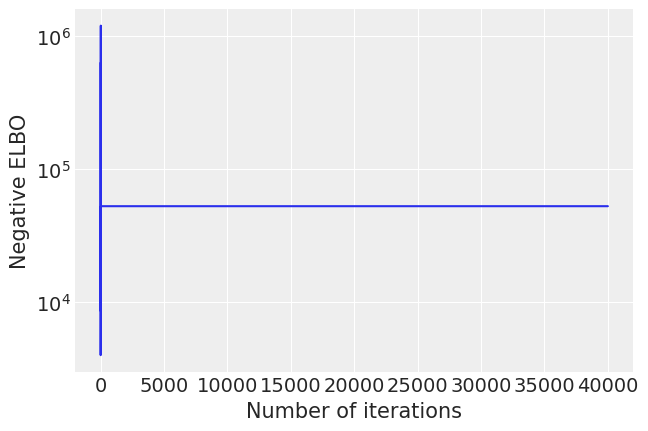

In [6]:
plt.plot(advi.losses['loss'])
plt.xlabel('Number of iterations')
plt.ylabel('Negative ELBO')
plt.yscale('log')

Text(0, 0.5, 'Average decrease in loss')

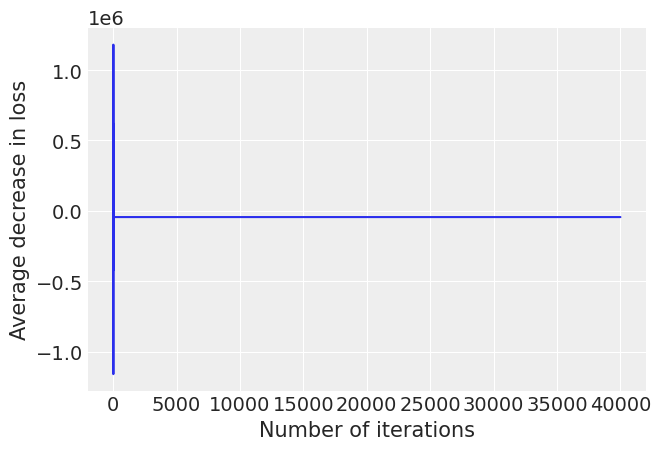

In [7]:
plt.plot(advi.losses['moving_loss'])
plt.xlabel('Number of iterations')
plt.ylabel('Average decrease in loss')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13fea4550>,
      dtype=object)

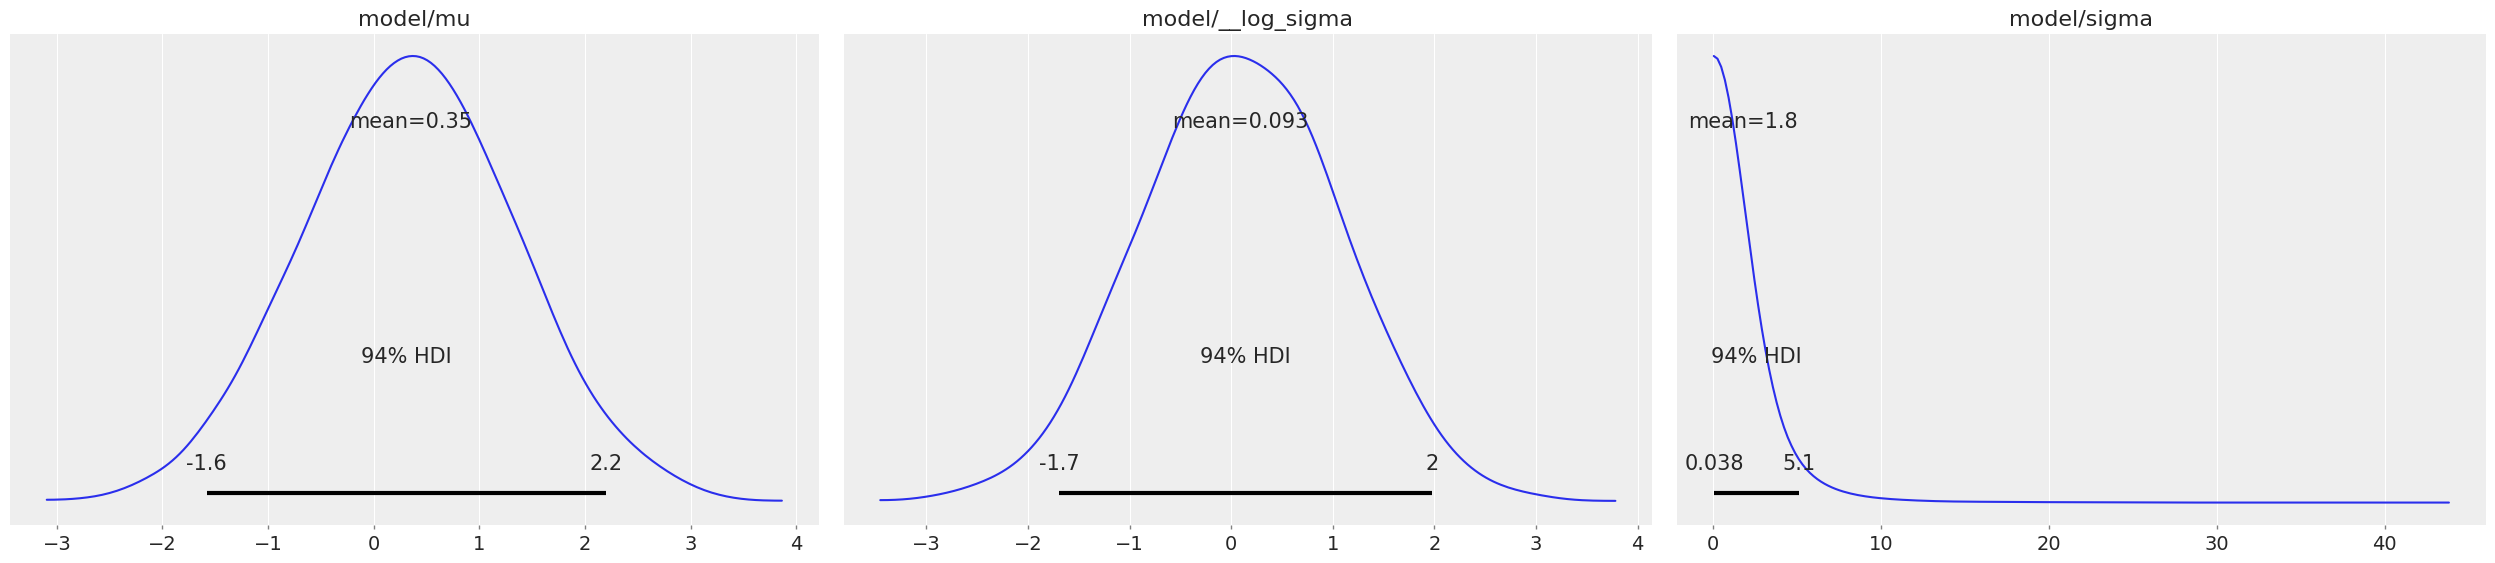

In [8]:
# Posterior is even worse
az.plot_posterior(advi.approximation.sample(10000))

## Playing around with Optimizers of PyMC3

In [9]:
mu = np.zeros(2, dtype=np.float32)
cov = np.array([[1, 0.8], [0.8, 1]], dtype=np.float32)
data = np.random.multivariate_normal(mu, cov, size=10000)

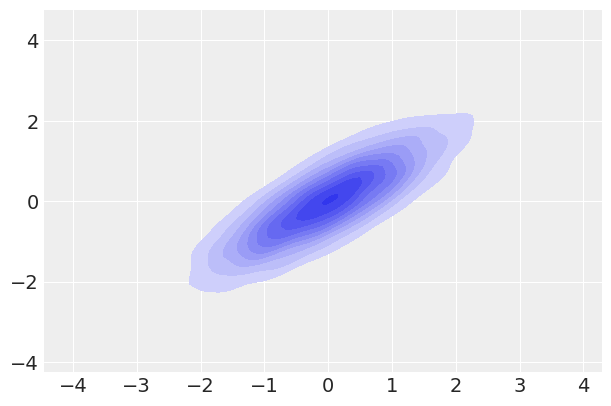

In [10]:
sns.kdeplot(data[:, 0], data[:, 1], shade=True, shade_lowest=False);

In [11]:
@pm4.model
def model():
    density = yield pm4.MvNormalCholesky("density", loc=mu, scale_tril=cov)

In [12]:
optimizers = [
    tf.optimizers.Adadelta(learning_rate=1.0, rho=0.95, epsilon=1e-6),
    tf.optimizers.Adagrad(learning_rate=1.0, epsilon=1e-6),
    tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
    tf.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
    tf.optimizers.SGD(learning_rate=1e-3),
]

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
The signature for `trace_fn`s passed to `minimize` has changed. Trace functions now take a single `traceable_quantities` argument, which is a `tfp.math.MinimizeTraceableQuantities` namedtuple containing `traceable_quantities.loss`, `traceable_quantities.gradients`, etc. Please update your `trace_fn` definition.


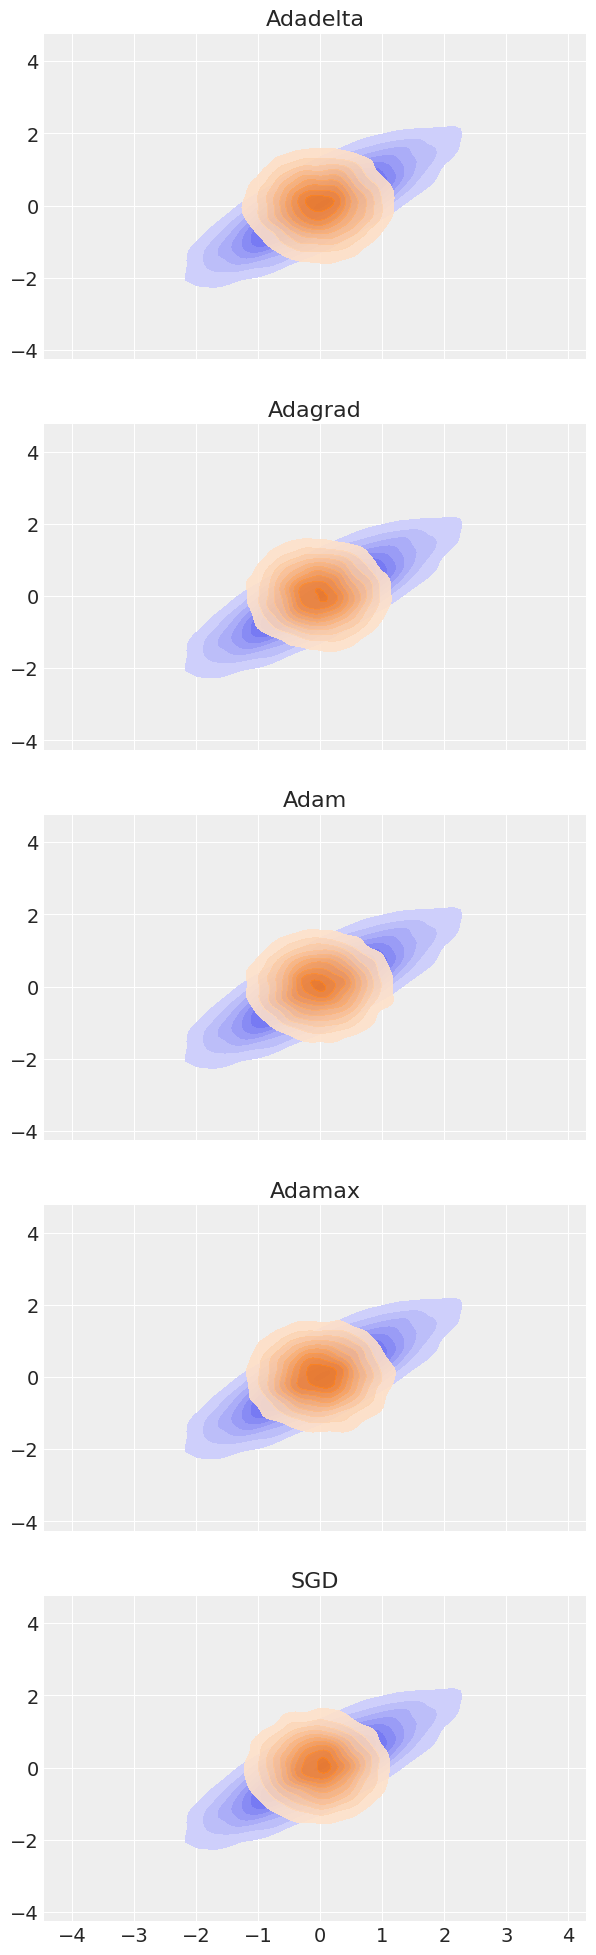

In [13]:
rows = [n for n in range(0, 5)]
names = ["Adadelta", "Adagrad", "Adam", "Adamax", "SGD"]
f, axes = plt.subplots(5, 1, figsize=(7, 25), squeeze=False, sharex=True)

for row, name, optimizer in zip(rows, names, optimizers):
    advi = pm4.fit(model(), num_steps=40000, optimizer=optimizer)
    pymc4_samples = advi.approximation.sample(10000)
    pymc4_samples = np.squeeze(pymc4_samples.posterior['model/density'].values, axis=0)
    
    # Plot the fit
    ax = sns.kdeplot(
        data[:, 0], 
        data[:, 1], 
        shade=True, 
        shade_lowest=False, 
        ax=axes[row, 0]
    )
    ax.set_title(name)
    sns.kdeplot(
        pymc4_samples[:, 0],
        pymc4_samples[:, 1], 
        shade=True,
        shade_lowest=False,
        alpha=0.9,
        ax=axes[row, 0],
    )

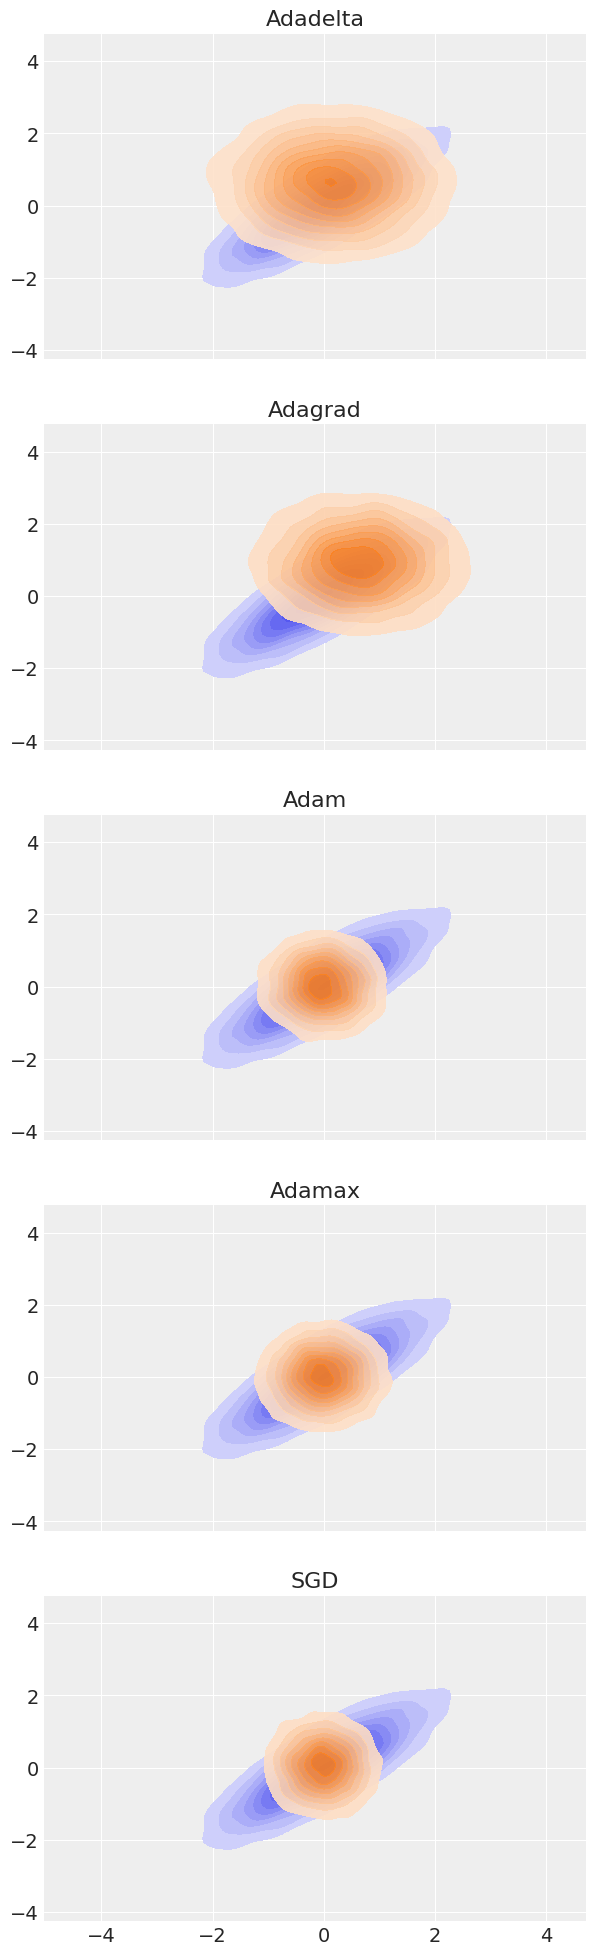

In [14]:
# Default value for tf.optimizers values

rows = [n for n in range(0, 5)]
names = ["Adadelta", "Adagrad", "Adam", "Adamax", "SGD"]
f, axes = plt.subplots(5, 1, figsize=(7, 25), squeeze=False, sharex=True)

for row, name in zip(rows, names):
    advi = pm4.fit(model(), num_steps=40000, optimizer=getattr(tf.optimizers, name)())
    pymc4_samples = advi.approximation.sample(10000)
    pymc4_samples = np.squeeze(pymc4_samples.posterior['model/density'].values, axis=0)
    
    # Plot the fit
    ax = sns.kdeplot(
        data[:, 0], 
        data[:, 1], 
        shade=True, 
        shade_lowest=False, 
        ax=axes[row, 0]
    )
    ax.set_title(name)
    sns.kdeplot(
        pymc4_samples[:, 0],
        pymc4_samples[:, 1], 
        shade=True,
        shade_lowest=False,
        alpha=0.9,
        ax=axes[row, 0],
    )

## Tests

In [15]:
# Normal conjugate model with known variance
unknown_posterior_mean = 68
known_posterior_var = 16

data_points = 1000
data = np.random.normal(unknown_posterior_mean, known_posterior_var, size=data_points)

prior_mean = 72
prior_var = 36

@pm4.model
def model():
    mu = yield pm4.Normal('mu', prior_mean, prior_var)
    ll = yield pm4.Normal('ll', mu, known_posterior_var, observed=data)

mean_field = pm4.fit(model())
estimated_mean = (prior_mean/prior_var + (data_points*np.mean(data)/known_posterior_var))/(1/prior_var + data_points/known_posterior_var)

In [16]:
print(estimated_mean)

68.08235290564497


In [17]:
# Can be done similarly with known mean